# Model Training

Created for Urban Heat Island Project

In [94]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Core Data Science
import numpy as np
import pandas as pd
from scipy import stats,ndimage
from scipy.stats import boxcox,pearsonr,spearmanr
import time
from math import ceil

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial Analysis
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds
from osgeo import gdal, osr
from pyproj import CRS
from pyproj import Transformer
from shapely.geometry import Point

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from bayes_opt import BayesianOptimization

# Utilities
import os
import re
import glob
from tqdm import tqdm
import json
import joblib
import sys
import concurrent.futures

## Path settings

In [81]:
# Get the working directory of the Notebook and dynamically calculate the project root directory (two levels up)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the project root directory to the module search path so Python can dynamically find the config file
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import the global instance path_config from path_config.py and rename it as config
from path_config import path_config as config

## Extracting Band Values from the GeoTIFF Image

In [55]:
#Store the optimal grid resolution in a dictionary

raster_dict = {}

for raster, res in config.rasters_res.items():
    raster_dict[f"{raster}_res_path"] = os.path.join(config.resampled_rasters_path, raster, f"{raster}_res{res}.tif")

raster_names = list(raster_dict.keys())
raster_paths = list(raster_dict.values())

In [56]:
def extract_raster(raster_path, csv_path, column_name):
    # Load the GeoTIFF data
    data = rxr.open_rasterio(raster_path)
    tiff_crs = data.rio.crs

    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)
    values = []

    # Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Convert coordinates
        x, y = transformer.transform(lon, lat)
        
        # Use the transformed coordinates to retrieve the value
        value = data.sel(x=x, y=y, method="nearest").values
        # Ensure a single value is obtained
        values.append(float(value[0]))

    result_df = pd.DataFrame({column_name: values})
    
    return result_df

## Model training

In [57]:
training_data = pd.read_csv(config.training_data_path)
training_data

,UHI Index,build_dens_wnh_res_path,anh_res_path,meanheigh_impervious_res_path,ndli_ndvi_res_path,meanheigh_buildcove_res_path,ndvi_res_path
0,1.030289,-4.146193,6.239490,8.288464,0.034178,2.000319,0.132893
1,1.030289,-4.143790,6.248621,8.288070,0.034226,2.001934,0.132796
2,1.023798,-4.143790,6.248621,8.284111,0.034363,2.001502,0.131980
3,1.023798,-4.143790,6.248621,8.284111,0.034363,2.001502,0.131980
4,1.021634,-4.143790,6.248621,8.280119,0.034516,2.001010,0.131129
...,...,...,...,...,...,...,...
11224,0.972470,-1.358358,87.046356,8.763112,0.092404,2.265169,0.263834
11225,0.972470,-1.358358,87.046356,8.763112,0.092404,2.265169,0.263834
11226,0.981124,-1.358358,87.046356,8.762625,0.092891,2.265605,0.264146
11227,0.981245,-1.331688,86.915749,8.762625,0.092891,2.265605,0.264146


In [58]:
# Separate features (X) and target variable (y)
X = training_data.drop(columns=['UHI Index']).values
y = training_data['UHI Index'].values

# Check if there are any NaN or inf values in the data
print("X has NaN:", np.isnan(X).any(), "X has inf:", np.isinf(X).any())
print("y has NaN:", np.isnan(y).any(), "y has inf:", np.isinf(y).any())

# Feature scaling
X_scaled = X

# Split data: 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=123)

X has NaN: False X has inf: False
y has NaN: False y has inf: False


### Random Forest model optimization

In [59]:
# In order to facilitate drawing presentation, the variable name needs to be modified here
rename_list = config.rename_list

def show_feature_importances():
    # Get feature importances
    importances = model.feature_importances_

    # Combine feature names with importances
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Select the 10 most important features (sorted in descending order)
    top_important_10 = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

    corrs = []
    for fname in top_important_10['feature']:
        corr, _ = spearmanr(training_data[fname], training_data['UHI Index'])
        corrs.append(corr)
    top_important_10 = top_important_10.copy()
    top_important_10['spearman_corr'] = corrs

    # Print the 10 most important features with renamed labels
    print("10 Most Important Features:")
    top_important_10_display = top_important_10.copy()
    top_important_10_display['feature'] = top_important_10_display['feature'].map(rename_list).fillna(top_important_10_display['feature'])
    print(top_important_10_display)

    # Plot a horizontal bar chart of the 10 most important features, sorted from high to low, with renamed labels
    plt.figure(figsize=(4.5, 6))
    plt.barh(top_important_10_display['feature'], top_important_10_display['importance'])
    plt.xlabel('Importance',size = 12)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.gca().invert_yaxis()  # Invert y-axis so the most important feature appears at the top
    plt.savefig(os.path.join(config.figures_path, 'feature_importance.png'), dpi=300, bbox_inches='tight',transparent=True)
    plt.show()
    
def show_feature_importances_2():
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame(
        {'feature': feature_names, 'importance': importances}
    )
    top10 = (
        feature_importance_df
        .sort_values('importance', ascending=False)
        .head(10)
        .copy()
    )
    top10['spearman_corr'] = [
        spearmanr(training_data[f], training_data['UHI Index'])[0]
        for f in top10['feature']
    ]
    
    top10['feature'] = (
        top10['feature']
        .map(rename_list)
        .fillna(top10['feature'])
    )

    plt.figure(figsize=(10, 3))
    plt.bar(
        x=top10['feature'],
        height=top10['importance']
    )
    plt.ylabel('Importance', fontsize=12)
    plt.xticks(rotation=30, ha='right', fontsize=11) 
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            config.figures_path,
            'feature_importance_vertical.png'
        ),
        dpi=300, bbox_inches='tight', transparent=True
    )
    plt.show()


Model saved to: D:\EY_2025\model\models


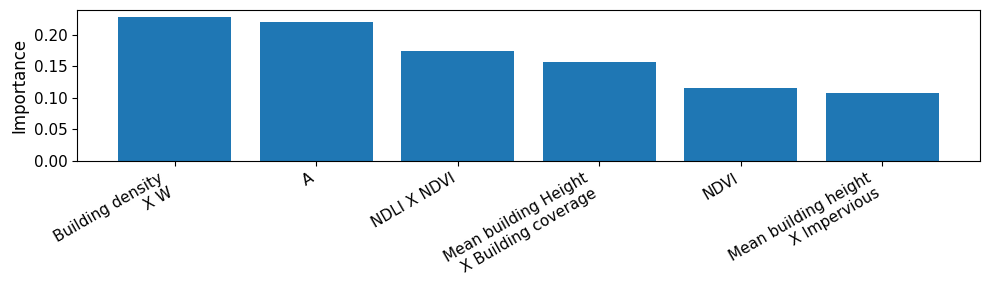

In [60]:
# base model

# Train Random Forest on the training set
model = RandomForestRegressor(n_estimators=200, max_depth=35, max_features='sqrt', min_samples_split=2, min_samples_leaf=1)
model.fit(X_train, y_train)

model_saves_path = os.path.join(config.model_path, "bese_model.pkl")
joblib.dump(model, model_saves_path)
print("Model saved to:", config.model_path)

# ===== New Addition: Print and Plot the 20 Least Important Features =====
# Get feature names in original order
feature_names = training_data.drop(columns=['UHI Index']).columns

show_feature_importances_2()

|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 2         | 0.9460167 | 224.11729 | 21.445573 | 3.8148116 | 3.2052590 |
| 3         | 0.9416018 | 229.86724 | 26.924258 | 9.8461135 | 3.7393189 |
| 4         | 0.9460330 | 170.23297 | 25.684700 | 4.7454241 | 3.9161988 |
| 5         | 0.9167935 | 159.64306 | 12.387115 | 5.1843540 | 3.9519816 |
| 6         | 0.9438663 | 95.622932 | 17.018070 | 6.2524109 | 3.1273103 |
| 7         | 0.9449853 | 208.60023 | 43.977271 | 7.7956425 | 3.4440940 |
| 8         | 0.9561421 | 230.61084 | 22.918356 | 4.8943092 | 1.9130529 |
| 9         | 0.9522972 | 123.42851 | 35.239044 | 2.7368395 | 2.7348046 |
| 10        | 0.9514402 | 157.71569 | 29.747403 | 5.4066423 | 2.2490448 |
| 11        | 0.9413865 | 156.58782 | 45.735566 | 9.5532801 | 3.0073467 |
| 12        | 0.9410747 | 205.98823 | 14.624735 | 4.5382838 | 2.6593048 |
| 13        | 0.9388330 | 266.57728 | 

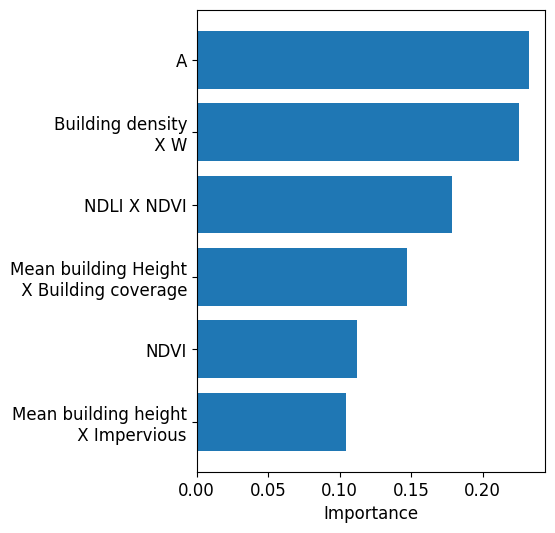

In [61]:
# Define the function to optimize
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # Convert parameters to integers
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    # Initialize the model with given parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features='sqrt',
        random_state=123
    )
    
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    
    # Return the mean score
    return scores.mean()

# Define parameter bounds for Bayesian Optimization
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (10, 50),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=123
)

# Perform optimization
optimizer.maximize(init_points=20, n_iter=100)

# Extract the best parameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

# Train Random Forest with optimized parameters
model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features='sqrt',
    random_state=123
)
model.fit(X_train, y_train)

model_saves_path = os.path.join(config.model_path, "best_rf.pkl")
joblib.dump(model, model_saves_path)
print("Model saved to:", config.model_path)

# Calculate Spearman correlation for the top 10 features

show_feature_importances()

In [62]:
import json

with open(os.path.join(config.data_dir, "best_params.json"), "w") as f:
    json.dump(best_params, f, indent=4)

## Training Results

### skl_model

In [63]:
def skl():
    skl_model = joblib.load(load_model_path)

    # Predict on training data
    insample_predictions = skl_model.predict(X_train)
    r2_train = r2_score(y_train, insample_predictions)
    print("Training set R² score:", r2_train)

    # Predict on test data
    outsample_predictions = skl_model.predict(X_test)
    r2_test = r2_score(y_test, outsample_predictions)
    print("Test set R² score:", r2_test)

In [64]:
load_model_path = os.path.join(config.model_path,"bese_model.pkl")
skl()

Training set R² score: 0.9938678326681732
Test set R² score: 0.9636005823264997


In [65]:
load_model_path = os.path.join(config.model_path,"best_rf.pkl")
skl()

Training set R² score: 0.9939489407610553
Test set R² score: 0.9636443535628251


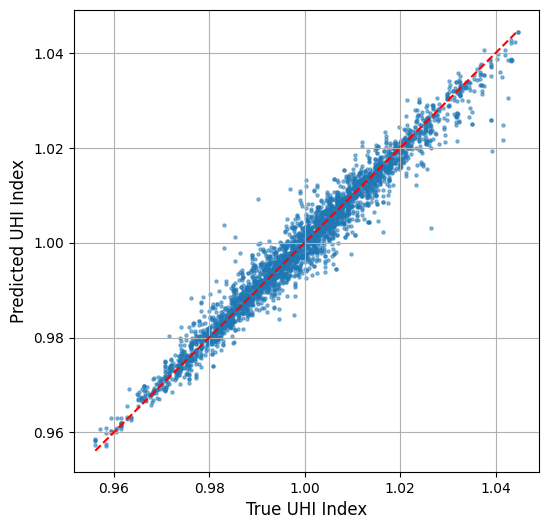

In [66]:
# 使用最佳隨機森林模型 (best_rf) 預測測試集，並繪製真實值與預測值的散布圖

# 載入最佳模型
best_rf_model = joblib.load(os.path.join(config.model_path, "best_rf.pkl"))

# 預測測試集
y_test_pred = best_rf_model.predict(X_test)

# 繪製散布圖
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5, s=5)
plt.xlabel("True UHI Index", fontsize=12)
plt.ylabel("Predicted UHI Index", fontsize=12)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()

### Use all the training data from the training set and build pipeline

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.special import boxcox1p
from joblib import dump

class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    """可序列化的 Box-Cox(+1) 轉換器"""
    def __init__(self, lambda_dict):
        self.lambda_dict = lambda_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col, lmbda in self.lambda_dict.items():
            if col in X.columns:
                X[col] = boxcox1p(X[col], lmbda)
        return X

TARGET_COL = "UHI Index"
feature_cols = training_data.columns.drop(TARGET_COL)

X = training_data[feature_cols]
y = training_data[TARGET_COL]

print("X has NaN:", np.isnan(X.values).any(), "X has inf:", np.isinf(X.values).any())
print("y has NaN:", np.isnan(y.values).any(), "y has inf:", np.isinf(y.values).any())

pipeline = Pipeline([
    ("boxcox", BoxCoxTransformer(config.lambda_dict)),
    ("rf", RandomForestRegressor(
        n_estimators     = best_params["n_estimators"],
        max_depth        = best_params["max_depth"],
        min_samples_split= best_params["min_samples_split"],
        min_samples_leaf = best_params["min_samples_leaf"],
        n_jobs           = -1,
        random_state     = 42,
    )),
])

pipeline.fit(X, y)

os.makedirs(config.model_path, exist_ok=True)
model_save_path = os.path.join(config.model_path, "final_model.joblib")
dump(pipeline, model_save_path, compress=3)

print("Pipeline 已儲存至:", model_save_path)


X has NaN: False X has inf: False
y has NaN: False y has inf: False
Pipeline 已儲存至: D:\EY_2025\model\models\final_model.joblib


### Test the training set using the trained model

In [86]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [87]:
# Read the test dataset (containing only basic info like latitude and longitude)
test_df = pd.read_csv(config.test_csv_path)
col_list = config.cols_to_keep  # Get the list of raster names from the configuration

# --------------------------------------------------
# 1. Extract raster environmental factors (same as training set)
# --------------------------------------------------
test_env = test_df.copy()

# Only extract environmental factors in col_list
for raster_name in col_list:
    if raster_name in raster_dict:
        raster_path = raster_dict[raster_name]
        # Call extract_raster to get the raster values (column name uses raster_name)
        raster_values = extract_raster(raster_path, config.test_csv_path, raster_name)
        # Concatenate the extracted results with the original test dataset
        test_env = pd.concat([test_env, raster_values], axis=1)
    
combined_test_data = test_env
combined_test_data

Mapping values: 100%|██████████| 1040/1040 [00:00<00:00, 1266.14it/s]


,Longitude,Latitude,UHI Index,build_dens_wnh_res_path,anh_res_path,meanheigh_impervious_res_path,ndli_ndvi_res_path,meanheigh_buildcove_res_path,ndvi_res_path
0,-73.971665,40.788763,NaN,0.410747,71.138123,3709.248047,0.111639,20.541735,0.225150
1,-73.971928,40.788875,NaN,0.408339,71.752747,3647.618896,0.110774,20.628777,0.218332
2,-73.967080,40.789080,NaN,0.390570,72.209457,4434.755371,0.115456,19.783899,0.280691
3,-73.972550,40.789082,NaN,0.408554,73.386246,3536.140869,0.109046,20.705355,0.204664
4,-73.969697,40.787953,NaN,0.415933,68.902603,4091.186768,0.115463,20.393873,0.260612
...,...,...,...,...,...,...,...,...,...
1035,-73.919388,40.813803,NaN,0.011507,8.991934,4121.754395,0.039822,14.817589,0.140440
1036,-73.931033,40.833178,NaN,0.032902,25.525530,4227.448730,0.054523,13.227018,0.162427
1037,-73.934647,40.854542,NaN,0.046132,31.710167,2417.451416,0.077956,11.176053,0.138736
1038,-73.917223,40.815413,NaN,0.012014,7.499881,4116.415527,0.037801,15.625856,0.151796


In [ ]:
# Use the selected features for prediction
# X_test_features = combined_test_data_yeojohnson[selected_features]
X_test_features = combined_test_data.drop(columns=["UHI Index","Longitude","Latitude"])

# Make predictions
# Load the final pipeline model
test_model = load(model_save_path)
test_predictions = test_model.predict(X_test_features)

# Add prediction results to the test dataset
combined_test_data["UHI Index"] = test_predictions

In [90]:
# Save the test dataset with prediction results to a CSV file
submit_data = combined_test_data.iloc[:,0:3]
submit_data.to_csv(config.submit_data_path, index=False)
submit_data

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.972440
1,-73.971928,40.788875,0.972872
2,-73.967080,40.789080,0.969904
3,-73.972550,40.789082,0.974963
4,-73.969697,40.787953,0.969410
...,...,...,...
1035,-73.919388,40.813803,1.003455
1036,-73.931033,40.833178,1.020540
1037,-73.934647,40.854542,1.015106
1038,-73.917223,40.815413,1.013618


In [91]:
# 變數篩選

# Training set R² score: 0.9938424443509261
# Test set R² score: 0.9632118345492908

# 變數篩選 + box-cox 轉換

# Training set R² score: 0.9939238374057595
# Test set R² score: 0.9635363607896023

# 變數篩選 + box-cox 轉換 + 模型調教

# Training set R² score: 0.9939489407610553
# Test set R² score: 0.9636443535628251


In [95]:
!jupyter nbconvert --to script train.ipynb

[NbConvertApp] Converting notebook train.ipynb to script
[NbConvertApp] Writing 14794 bytes to train.py
